In [42]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.svm import SVC
from collections import deque
from imutils import face_utils
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [43]:
# Specify the directory and image file name
directory = "train/angry"
image_file = "Training_3908.jpg"  # Ensure the file extension is correct
image_path = os.path.join(directory, image_file)

# Check if the file exists
if os.path.exists(image_path):
    print(f"Image found at: {image_path}")
    # Open and display the image using PIL
    img = Image.open(image_path)
    img.show()  # Opens the image in the default image viewer
else:
    print(f"Image file not found: {image_path}")

Image found at: train/angry\Training_3908.jpg


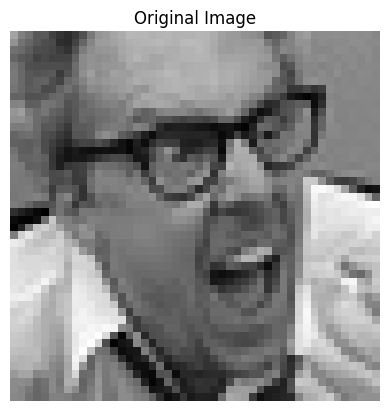

(48, 48, 3)


In [44]:
image = cv2.imread("train/angry/Training_3908.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")  
plt.title("Original Image")
plt.show()
print(image.shape)

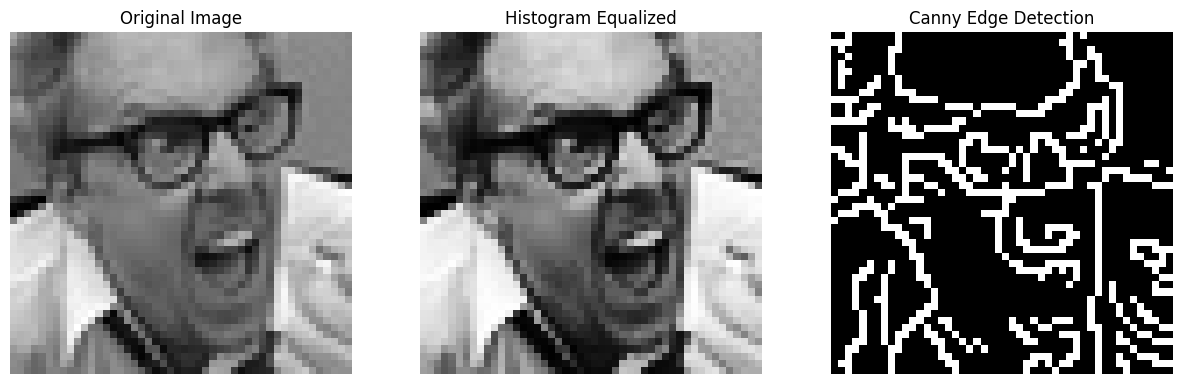

In [45]:
# Load Image
image = cv2.imread("train/angry/Training_3908.jpg", cv2.IMREAD_GRAYSCALE)

# Apply Histogram Equalization for contrast enhancement
equalized_image = cv2.equalizeHist(image)

# Apply Gaussian Blur for noise reduction
blurred_image = cv2.GaussianBlur(equalized_image, (3, 3), 0)

# Apply Edge Detection (Canny)
edges = cv2.Canny(blurred_image, 100, 200)

# Display Original and Processed Images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(equalized_image, cmap='gray')
axes[1].set_title("Histogram Equalized")
axes[1].axis("off")

axes[2].imshow(edges, cmap='gray')
axes[2].set_title("Canny Edge Detection")
axes[2].axis("off")

plt.show()


In [46]:
# Specify the directory and image file name
directory = "train/angry"
image_file = "Training_3908.jpg"  # Ensure the file extension is correct

# Construct the full path to the image
image_path = os.path.join(directory, image_file)

# Check if the file exists
if os.path.exists(image_path):
    print(f"Image found at: {image_path}")


Image found at: train/angry\Training_3908.jpg


In [47]:
def calculate_class_weights(dataset_path):
    class_counts = {}
    total_images = 0
    class_names = []

    # Iterate through each folder (class) and count images
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            image_count = len(os.listdir(folder_path))
            class_counts[folder] = image_count
            total_images += image_count
            class_names.append(folder)

    # Ensure consistent class order
    class_names.sort()
    class_indices = {name: idx for idx, name in enumerate(class_names)}

    # Create an array of labels corresponding to the dataset
    labels = np.concatenate([
        np.full(class_counts[folder], class_indices[folder])
        for folder in class_names
    ])

    # Compute class weights using sklearn
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Class Weights:")
    for folder, weight in zip(class_names, class_weights):
        print(f"Class: {folder}, Weight: {weight:.4f}")

    return class_weight_dict

# Path to your dataset (adjust as needed)
dataset_path = "train/"
class_weights = calculate_class_weights(dataset_path)


Class Weights:
Class: angry, Weight: 1.0266
Class: disgust, Weight: 9.4066
Class: fear, Weight: 1.0010
Class: happy, Weight: 0.5684
Class: neutral, Weight: 0.8260
Class: sad, Weight: 0.8491
Class: surprise, Weight: 1.2934


In [48]:
# Emotion Labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral' , 'Sad', 'Surprise']
num_classes = len(emotion_labels)

# Function to Load Images and Labels
def load_images_from_folder(base_path):
    X, y = [], []
    
    for emotion_index, emotion in enumerate(emotion_labels):
        folder_path = os.path.join(base_path, emotion.lower())  # e.g., "train/angry"
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            
            if image is not None:
                image = cv2.resize(image, (48, 48))  # Resize if necessary
                image = image / 255.0  # Normalize pixel values
                image = np.expand_dims(image, axis=-1)  # Reshape to (48, 48, 1)
                X.append(img_to_array(image))  # Convert to array
                y.append(emotion_index)  # Store corresponding label
    
    return np.array(X), np.array(y)

# Load Training & Testing Data
X_train, y_train = load_images_from_folder("train/")
X_test, y_test = load_images_from_folder("test/")

# Print Shapes
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")

Training Data Shape: (28709, 48, 48, 1), Testing Data Shape: (7178, 48, 48, 1)


In [49]:
print("Before Fixing:")
print("x_train shape:", X_train.shape)
print("x_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Before Fixing:
x_train shape: (28709, 48, 48, 1)
x_test shape: (7178, 48, 48, 1)
y_train shape: (28709,)
y_test shape: (7178,)


In [50]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=7)  # (28709, 7)
y_test = to_categorical(y_test, num_classes=7)  # (7178, 7)

print("Fixed y_train shape:", y_train.shape)  # (28709, 7)
print("Fixed y_test shape:", y_test.shape)  # (7178, 7)


Fixed y_train shape: (28709, 7)
Fixed y_test shape: (7178, 7)


In [51]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [52]:


def build_complex_cnn():
    model = Sequential([
        # First Conv Block
        Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second Conv Block
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third Conv Block
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Fourth Conv Block (Increased Complexity)
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        
        # Replace MaxPooling with GlobalAveragePooling (avoids dimension errors)
        GlobalAveragePooling2D(),

        # Fully Connected Layers
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),

        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),

        Dense(7, activation='softmax')  # 7 emotion classes
    ])

    # Compile the model with a lower learning rate for better convergence
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

emotion_model = build_complex_cnn()
emotion_model.summary()


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,607,367 (9.95 MB)

 Trainable params: 2,605,447 (9.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [53]:
# Regularized CNN Model
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [54]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs without improvement
    restore_best_weights=True # Restore the best weights
)

In [55]:
# Train the model with class weights
history = emotion_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weights  # Pass the computed class weights here
)

Epoch 1/20


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 173s 376ms/step - accuracy: 0.1676 - loss: 20.3112 - val_accuracy: 0.2143 - val_loss: 16.1530
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 166s 370ms/step - accuracy: 0.1943 - loss: 15.0610 - val_accuracy: 0.2718 - val_loss: 11.8457
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 173s 385ms/step - accuracy: 0.2195 - loss: 11.0117 - val_accuracy: 0.2634 - val_loss: 8.5692
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 157s 349ms/step - accuracy: 0.2536 - loss: 7.9853 - val_accuracy: 0.2898 - val_loss: 6.2698
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.2810 - loss: 5.8101 - val_accuracy: 0.3349 - val_loss: 4.6697
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.3225 - loss: 4.2636 - val_accuracy: 0.4354 - val_loss: 3.3580
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 176s 392ms/step - accuracy: 0.3520 - loss: 3.3147 - val_accuracy: 0.4514 - val_loss: 2.6786
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 159s 354ms/step - accuracy: 0.3809 - loss:

In [56]:
emotion_model.save('emotion_model.keras')

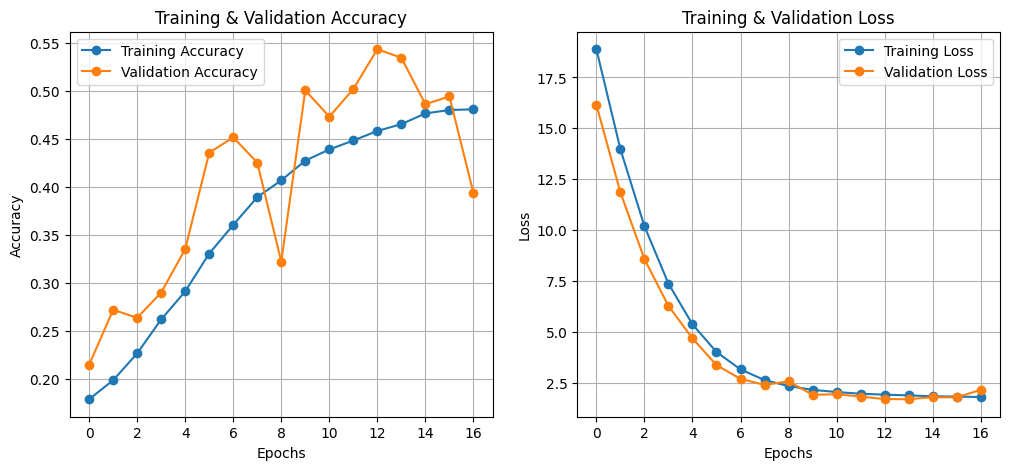

In [57]:
# Plot Accuracy Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [58]:
from tensorflow.keras.models import load_model

emotion_model = load_model('emotion_model.keras')


In [95]:
# Evaluate Model on Test Data
test_loss, test_acc = emotion_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.5614 - loss: 1.5535
Test Accuracy: 0.5857


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.5614 - loss: 1.5535
Test Accuracy: 0.5857, Test Loss: 1.5010


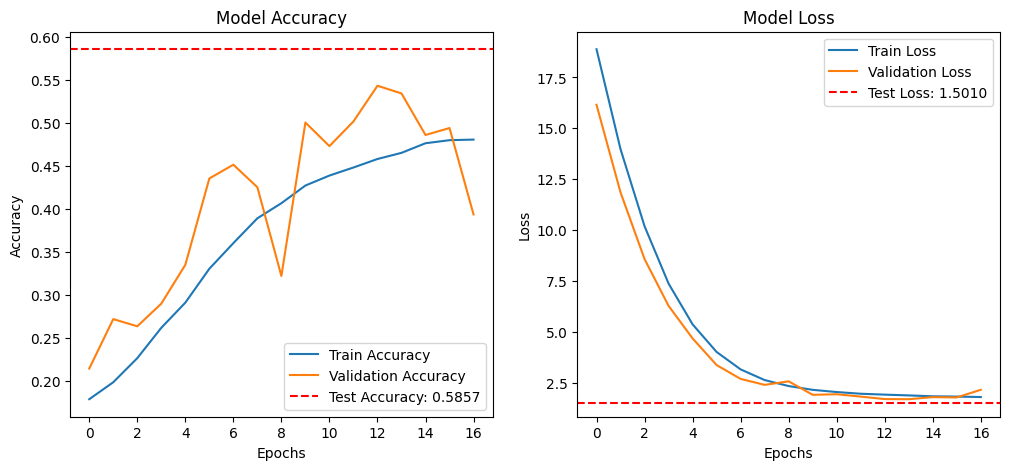

In [96]:
# Evaluate the model on the test set
test_loss, test_acc = emotion_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Plot Accuracy and Loss Curves
def plot_model_performance(test_history, test_acc, test_loss):
    plt.figure(figsize=(12, 5))

    # Accuracy Graph
    plt.subplot(1, 2, 1)
    plt.plot(test_history.history['accuracy'], label='Train Accuracy')
    plt.plot(test_history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Graph
    plt.subplot(1, 2, 2)
    plt.plot(test_history.history['loss'], label='Train Loss')
    plt.plot(test_history.history['val_loss'], label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the plotting function
plot_model_performance(history, test_acc, test_loss)

In [61]:
# Train the model and store the history
history2 = emotion_model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/2
449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 332ms/step - accuracy: 0.5853 - loss: 1.5517 - val_accuracy: 0.6096 - val_loss: 1.4408
Epoch 2/2
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 330ms/step - accuracy: 0.6590 - loss: 1.3321 - val_accuracy: 0.5857 - val_loss: 1.5010


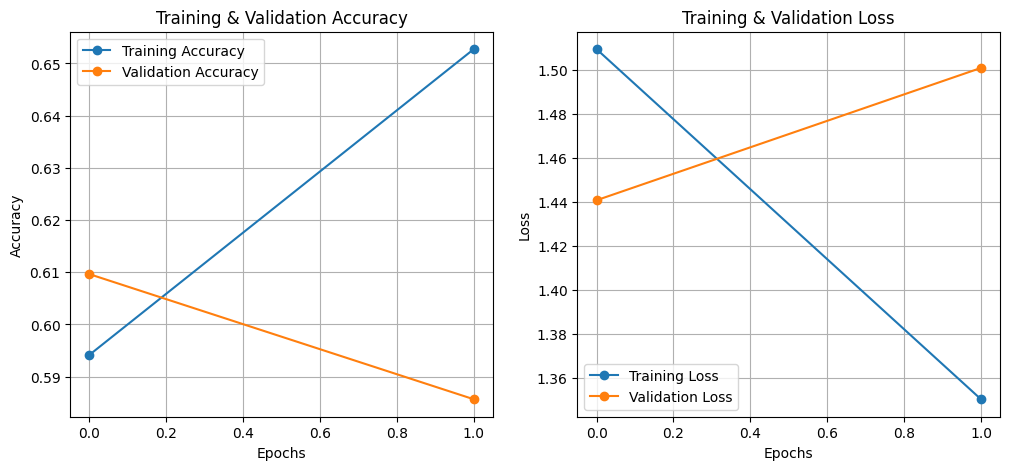

In [62]:
# Plot Accuracy Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss', marker='o')
plt.plot(history2.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

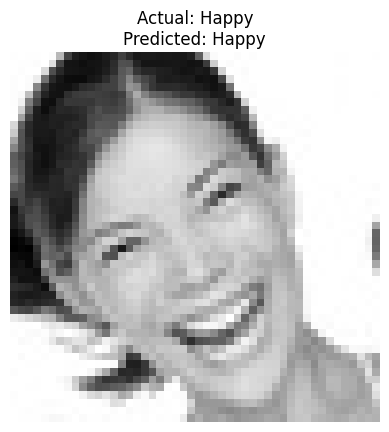

Actual Emotion: Happy
Predicted Emotion: Happy
Prediction Confidence: 0.9481


In [63]:
# Function to predict and display emotion with actual label
def predict_emotion(index=None):
    if index is None:
        index = random.randint(0, len(X_test) - 1)  # Random image if no index provided

    # Prepare the image for prediction
    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image, verbose=0)

    # Get predicted and actual labels
    predicted_label = emotion_labels[np.argmax(prediction)]
    actual_label = emotion_labels[np.argmax(y_test[index])]

    # Display the image with prediction and actual label
    plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
    plt.axis("off")
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.show()

    print(f"Actual Emotion: {actual_label}")
    print(f"Predicted Emotion: {predicted_label}")
    print(f"Prediction Confidence: {prediction[0][np.argmax(prediction)]:.4f}")

predict_emotion()

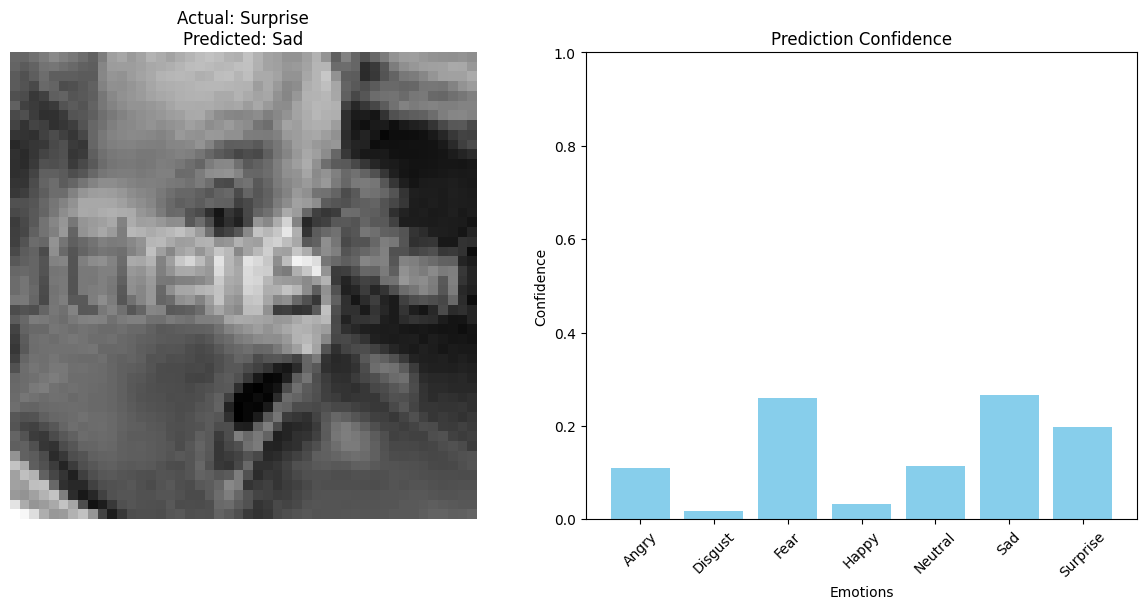

Actual Emotion: Surprise
Predicted Emotion: Sad
Confidence Scores: {'Angry': 0.109447666, 'Disgust': 0.018591369, 'Fear': 0.26082364, 'Happy': 0.032231, 'Neutral': 0.113896765, 'Sad': 0.2668951, 'Surprise': 0.1981144}


In [72]:
# Function to predict emotion and display confidence bar chart
def predict_emotion_with_confidence(index=None):
    if index is None:
        index = random.randint(0, len(X_test) - 1)  # Select random image if no index is provided

    # Prepare the image for prediction
    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image, verbose=0)

    # Get predicted and actual labels
    predicted_label = emotion_labels[np.argmax(prediction)]
    actual_label = emotion_labels[np.argmax(y_test[index])]

    # Display the image
    plt.figure(figsize=(12, 6))

    # Image subplot
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
    plt.axis("off")
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

    # Bar plot for confidence levels
    plt.subplot(1, 2, 2)
    plt.bar(emotion_labels, prediction[0], color='skyblue')
    plt.ylabel("Confidence")
    plt.xlabel("Emotions")
    plt.title("Prediction Confidence")
    plt.ylim(0, 1)  # Confidence ranges from 0 to 1
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Actual Emotion: {actual_label}")
    print(f"Predicted Emotion: {predicted_label}")
    print(f"Confidence Scores: {dict(zip(emotion_labels, prediction[0]))}")

# Call the function to predict and visualize
predict_emotion_with_confidence()

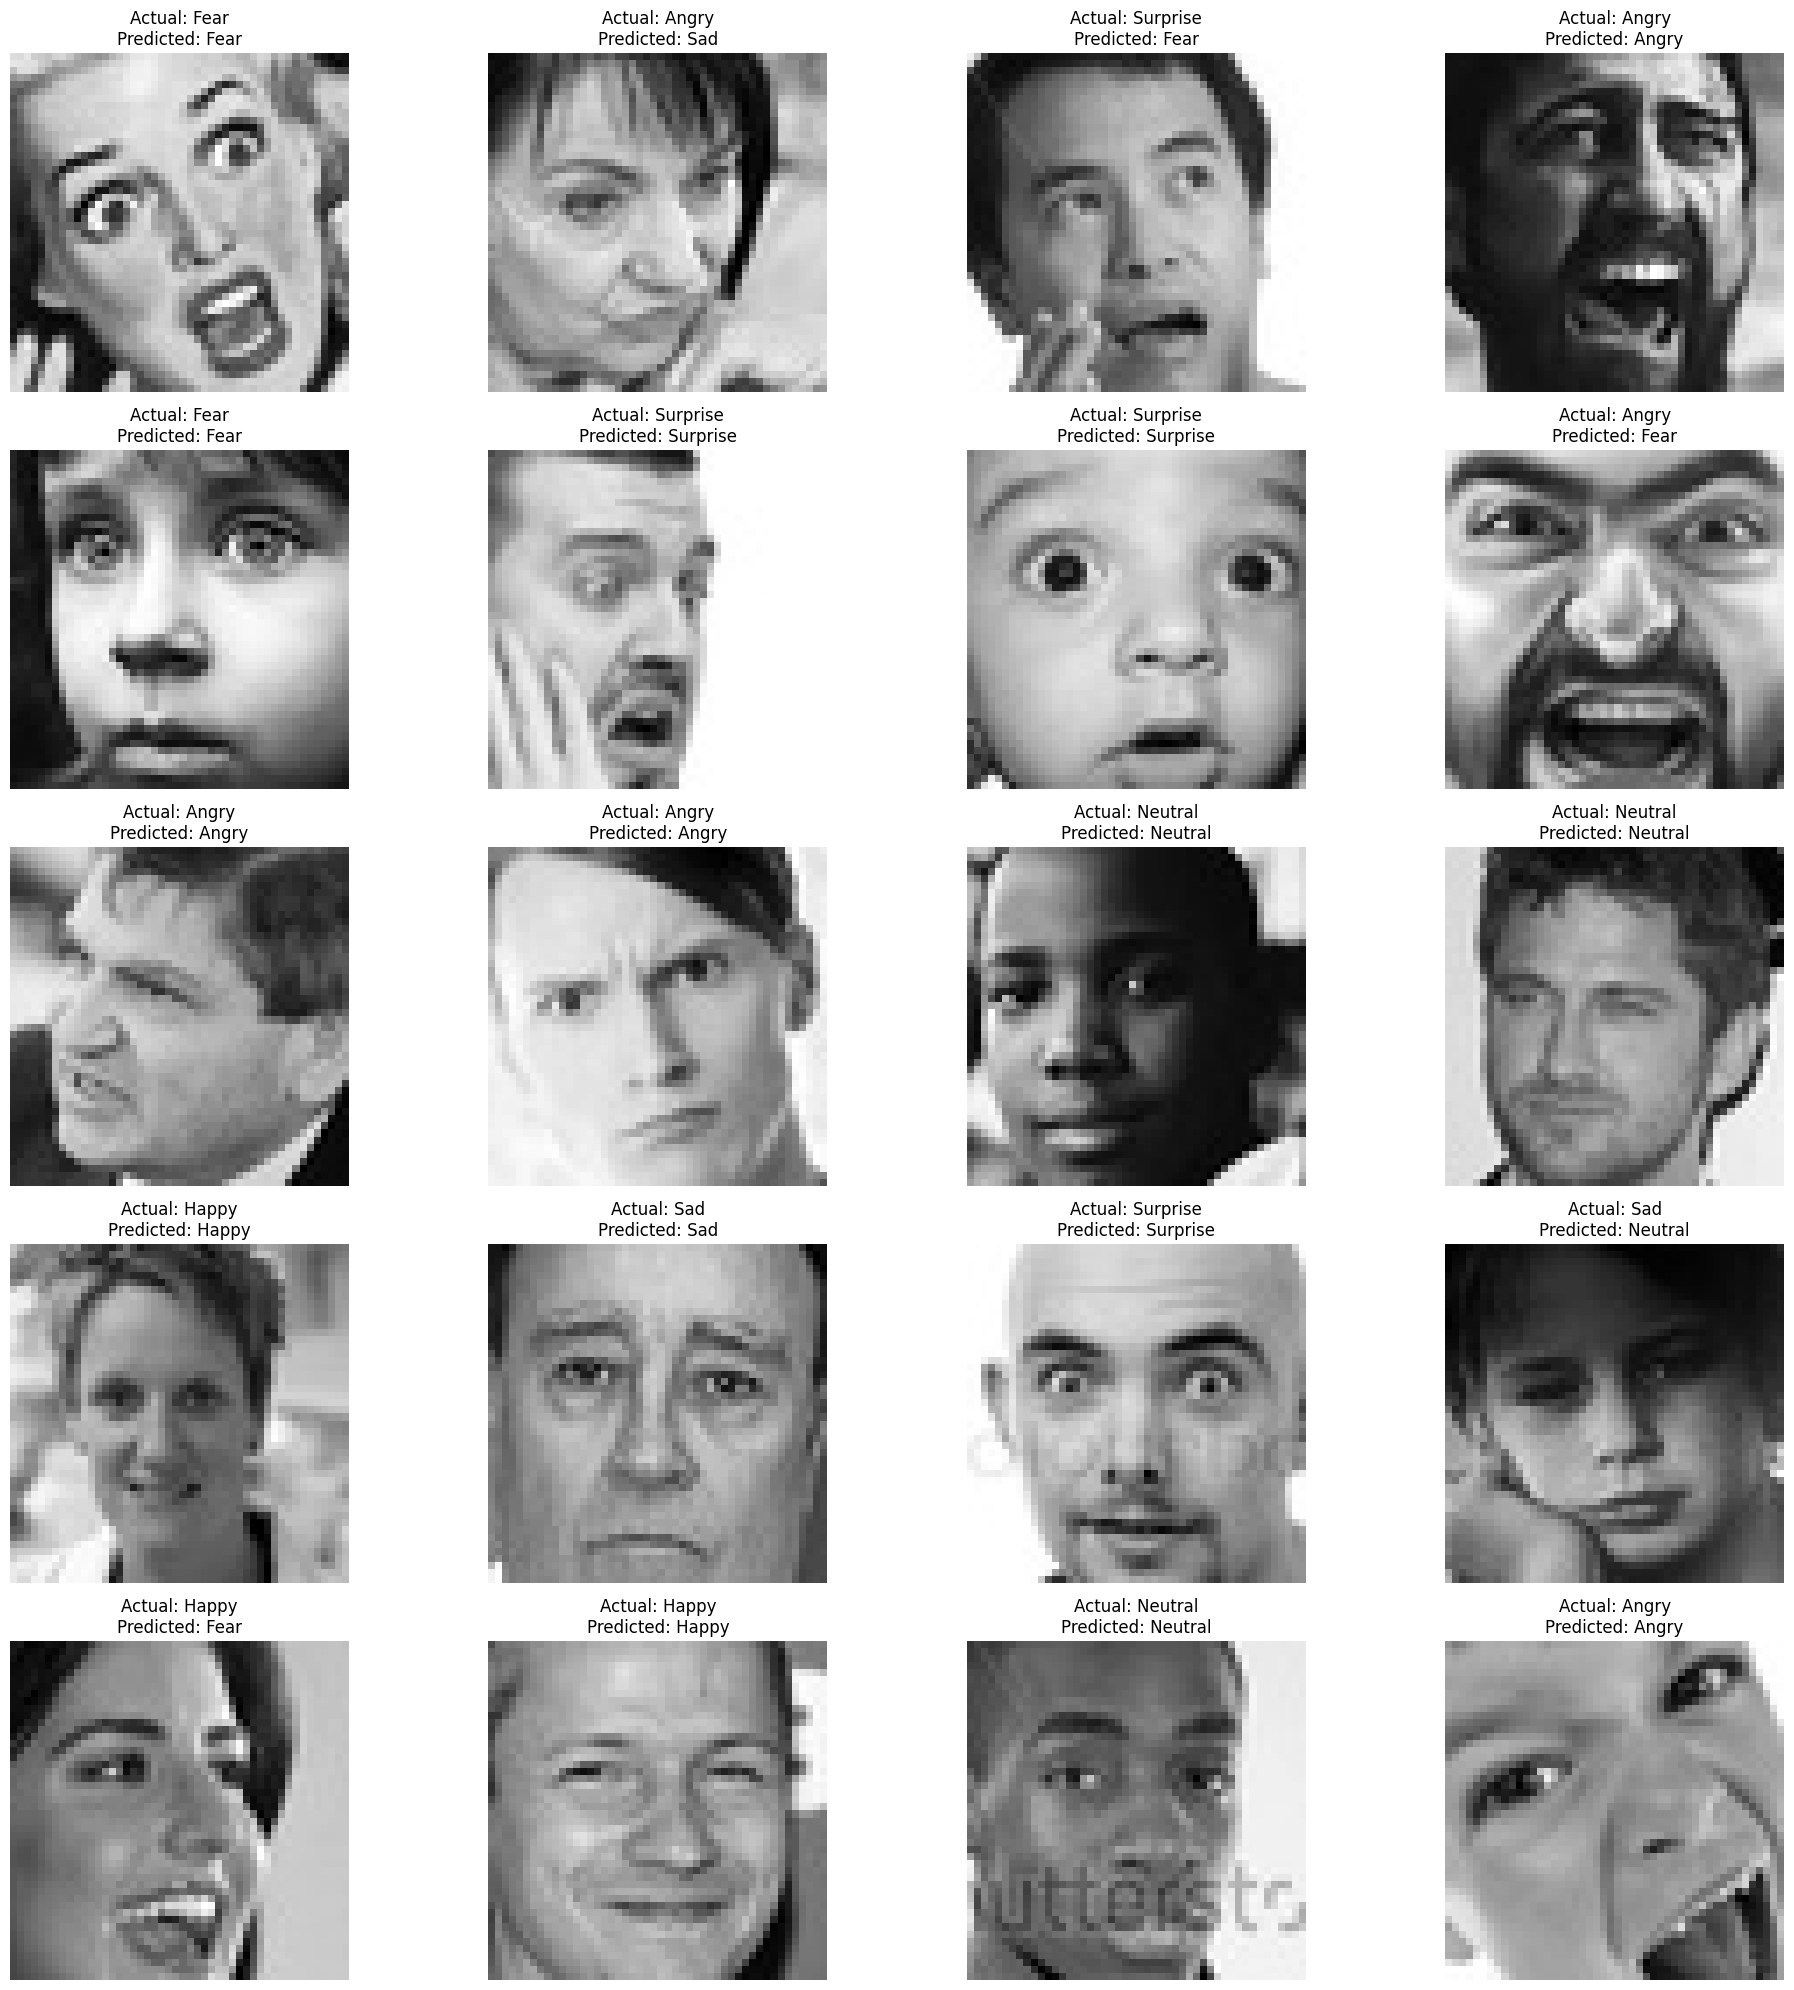

In [65]:
# Function to predict and display 20 random images with actual and predicted emotions
def predict_multiple_emotions(num_images=20):
    plt.figure(figsize=(20, 20))

    for i in range(num_images):
        # Select a random index from the test set
        index = random.randint(0, len(X_test) - 1)

        # Prepare the image for prediction
        test_image = np.expand_dims(X_test[index], axis=0)
        prediction = emotion_model.predict(test_image, verbose=0)
        
        # Get predicted and actual labels
        predicted_label = emotion_labels[np.argmax(prediction)]
        actual_label = emotion_labels[np.argmax(y_test[index])]

        # Display the image with predictions
        plt.subplot(5, 4, i + 1)
        plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
        plt.axis("off")
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

    plt.tight_layout()
    plt.show()

# Call the function to display 20 images with actual and predicted emotions
predict_multiple_emotions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


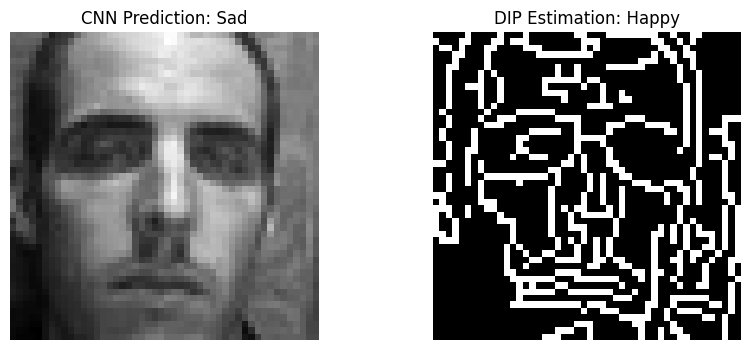

📌 CNN Model Predicted: Sad
📌 DIP-Based Estimation: Happy


In [66]:
def dip_based_estimation(gray_img):
    """Estimate emotion using basic DIP techniques."""
    edges = cv2.Canny(gray_img, 50, 150)  # Apply Canny Edge Detection
    mean_intensity = np.mean(gray_img)  # Average brightness
    edge_count = np.sum(edges > 100)  # Count strong edges

    # Simple rule-based emotion classification
    if edge_count > 1500 and mean_intensity < 80:
        return "Angry"
    elif edge_count < 500 and mean_intensity > 150:
        return "Neutral"
    elif edge_count > 1800:
        return "Surprise"
    elif mean_intensity < 50:
        return "Sad"
    else:
        return "Happy"

def predict_emotion(index=None):
    """Predict emotion using CNN and compare with DIP-based estimation."""
    if index is None:
        index = random.randint(0, len(X_test) - 1)

    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image)
    cnn_predicted_label = emotion_labels[np.argmax(prediction)]

    # Convert image to grayscale for DIP processing
    gray_img = X_test[index].reshape(48, 48) * 255  # Convert back to 8-bit range
    dip_predicted_label = dip_based_estimation(gray_img.astype(np.uint8))

    # Display results
    plt.figure(figsize=(10, 4))

    # CNN Prediction
    plt.subplot(1, 2, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.axis("off")
    plt.title(f"CNN Prediction: {cnn_predicted_label}")

    # DIP Prediction
    edges = cv2.Canny(gray_img.astype(np.uint8), 50, 150)
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    plt.title(f"DIP Estimation: {dip_predicted_label}")

    plt.show()

    # Print comparison
    print(f"📌 CNN Model Predicted: {cnn_predicted_label}")
    print(f"📌 DIP-Based Estimation: {dip_predicted_label}")

# Run on a random image
predict_emotion()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


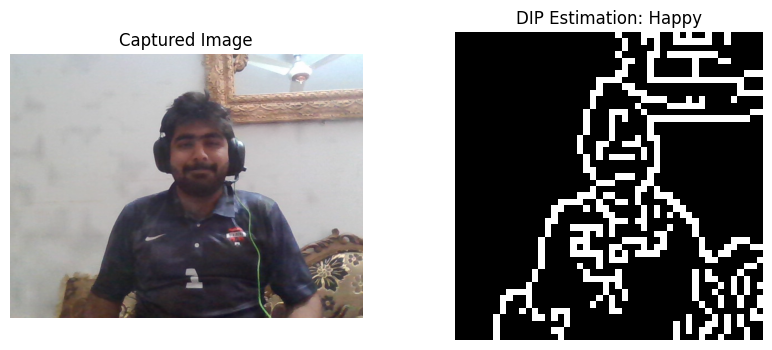

📌 CNN Model Predicted: Fear
📌 DIP-Based Estimation: Happy


In [78]:
def capture_image():
    """Capture an image from the webcam."""
    cap = cv2.VideoCapture(0)  # Open webcam
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None

    ret, frame = cap.read()  # Capture frame
    cap.release()  # Release webcam
    if not ret:
        print("Error: Could not capture image.")
        return None

    return frame

def preprocess_image(frame):
    """Convert to grayscale, resize to 48x48, and normalize."""
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_img = cv2.resize(gray_img, (48, 48))  # Resize to (48x48)
    normalized_img = resized_img / 255.0  # Normalize pixel values (0-1)
    return np.expand_dims(normalized_img, axis=(0, -1))  # Add batch & channel dims

def dip_based_estimation(gray_img):
    """Estimate emotion using basic DIP techniques."""
    gray_img = gray_img.astype(np.uint8)  # Convert to uint8 (0-255)
    
    edges = cv2.Canny(gray_img, 50, 150)  # Apply Canny Edge Detection
    mean_intensity = np.mean(gray_img)  # Average brightness
    edge_count = np.sum(edges > 100)  # Count strong edges

    # Simple rule-based emotion classification
    if edge_count > 1500 and mean_intensity < 80:
        return "Angry"
    elif edge_count < 500 and mean_intensity > 150:
        return "Neutral"
    elif edge_count > 1800:
        return "Surprise"
    elif mean_intensity < 50:
        return "Sad"
    else:
        return "Happy"

def predict_webcam_emotion():
    """Capture, preprocess, and predict emotion from a webcam image."""
    frame = capture_image()
    if frame is None:
        return

    # Preprocess image
    preprocessed_img = preprocess_image(frame)

    # CNN Prediction
    prediction = emotion_model.predict(preprocessed_img)
    cnn_predicted_label = emotion_labels[np.argmax(prediction)]

    # DIP Prediction
    dip_predicted_label = dip_based_estimation(preprocessed_img[0, :, :, 0] * 255)

    # Display Results
    plt.figure(figsize=(10, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Captured Image")

    # DIP Edge Detection
    edges = cv2.Canny((preprocessed_img[0, :, :, 0] * 255).astype(np.uint8), 50, 150)
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    plt.title(f"DIP Estimation: {dip_predicted_label}")

    plt.show()

    # Print Predictions
    print(f"📌 CNN Model Predicted: {cnn_predicted_label}")
    print(f"📌 DIP-Based Estimation: {dip_predicted_label}")

# Run webcam-based emotion prediction
predict_webcam_emotion()
